# **Housing Price Analysis**

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
zillow_df = pd.read_csv("/drive/data/data_zillow_house_prices.csv")
zillow_df = zillow_df.set_index('RegionName')
zillow_df = zillow_df.drop(columns=[i for i in zillow_df.columns if '-' not in i]).T
zillow_df.index = pd.to_datetime(zillow_df.index)

In [5]:
interest_df = pd.read_csv("/drive/data/data_interest_rates.csv")
interest_df["DATE"] = pd.to_datetime(interest_df["DATE"])
interest_df = interest_df.set_index("DATE")
interest_series = interest_df.resample(rule='M')['MORTGAGE30US'].mean()

In [10]:
print("Number of rows:", len(zillow_df.columns))
print(zillow_df.columns)
print(zillow_df.index)

Number of rows: 893
Index(['United States', 'New York, NY', 'Los Angeles, CA', 'Chicago, IL',
       'Dallas, TX', 'Houston, TX', 'Washington, DC', 'Miami, FL',
       'Philadelphia, PA', 'Atlanta, GA',
       ...
       'Pecos, TX', 'Atchison, KS', 'Spencer, IA', 'Sweetwater, TX',
       'Vermillion, SD', 'Zapata, TX', 'Ketchikan, AK', 'Craig, CO',
       'Lamesa, TX', 'Vernon, TX'],
      dtype='object', name='RegionName', length=893)
DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28',
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31'],
              dtype='datetime64[ns]', length=272, freq=None)


In [11]:
print("Number of missing data:", np.sum(np.sum(zillow_df.isnull())))
print("Minimum of interest rate:", np.min(interest_df))
print("Maximum of interest rate:", np.max(interest_df))

Number of missing data: 49519
Minimum of interest rate: 2.65
Maximum of interest rate: 18.63


#### Illustrate the figure for Boston, MA

<AxesSubplot:>

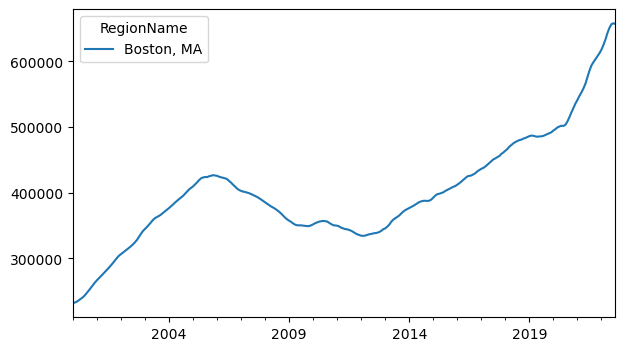

In [14]:
zillow_df.plot(y=['Boston, MA'], figsize=(7, 4))

In [15]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.formula.api import ols

start_time = pd.to_datetime('2010-01-01')
end_time = pd.to_datetime('2017-12-31')
train_boston_ts = zillow_df.loc[start_time: end_time, 'Boston, MA']
_, p, _, _, _, _ = adfuller(train_boston_ts)
print("ADF Test, p-value=", p)

ADF Test, p-value= 0.9787243261392025


In [16]:
def test_stationarity(series):
  _, p, _, _, _, _ = adfuller(series)
  print("ADF Test, p-value=", p)

def remove_trend(formula, data, print_summary=False):
  mdl = ols(formula, data).fit()
  if print_summary is True:
    print(mdl.summary())
  return mdl.resid

In [17]:
test_stationarity(train_boston_ts)
t_series = np.arange(len(train_boston_ts))
test_stationarity(remove_trend(
    formula='x ~ t',
    data={'x': train_boston_ts, 't': t_series}))
test_stationarity(remove_trend(
    formula='x ~ t + tt',
    data={'x': train_boston_ts, 't': t_series, 'tt': t_series**2}))
test_stationarity(remove_trend(
    formula='x ~ t + tt + ttt',
    data={'x': train_boston_ts, 't': t_series, 'tt': t_series**2, 'ttt': t_series**3}))

ADF Test, p-value= 0.9787243261392025
ADF Test, p-value= 0.03287906071428976
ADF Test, p-value= 0.03545054499297015
ADF Test, p-value= 0.0023274174117385487


#### Another way to stabelize a time series is to calculate the difference series.

In [18]:
start_time = pd.to_datetime('2010-01-01')
end_time = pd.to_datetime('2017-12-31')
train_boston_ts = zillow_df.loc[start_time: end_time, 'Boston, MA']
_, p, _, _, _, _ = adfuller(train_boston_ts)
print("ADF Test, p-value=", p)
_, p, _, _, _, _ = adfuller(train_boston_ts.diff(1).dropna())
print("ADF Test, p-value=", p)
_, p, _, _, _, _ = adfuller(train_boston_ts.diff(1).dropna().diff(1).dropna())
print("ADF Test, p-value=", p)

ADF Test, p-value= 0.9787243261392025
ADF Test, p-value= 0.5771690844120718
ADF Test, p-value= 3.052895844915407e-15


#### Illustrate the ACF/PACF figures:

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

detrend_boston_ts = remove_trend(
    formula = 'x ~ t',
    data = {'x': train_boston_ts, 't': t_series})

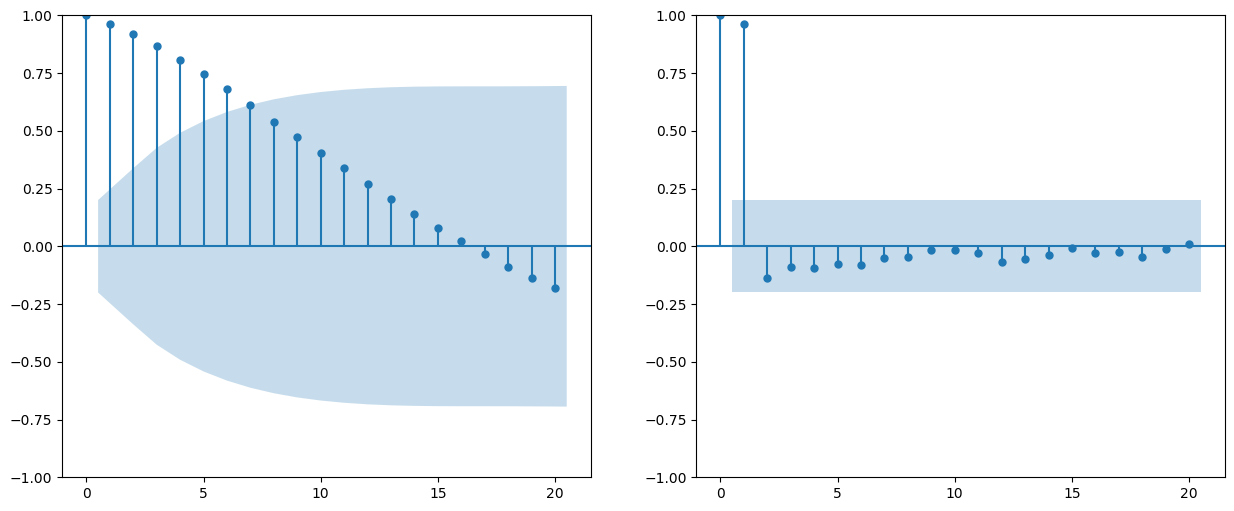

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
plot_acf(detrend_boston_ts, ax=axes[0], title="")
plot_pacf(detrend_boston_ts, ax=axes[1], title="")
plt.show()
plt.show()

p= 1 , MSE= 11573980.82623937
p= 2 , MSE= 9942713.487420518
p= 3 , MSE= 9941923.641506338
p= 4 , MSE= 9940353.883502934
p= 5 , MSE= 9830276.733207613


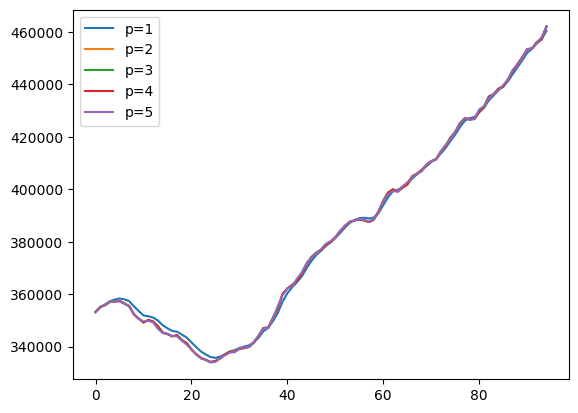

In [44]:
from statsmodels.tsa.arima.model import ARIMA

trend_mdl = ols(formula='x ~ t', data={'x': train_boston_ts, 't': t_series}).fit()
for p in [1, 2, 3, 4, 5]:
    mdl = ARIMA(detrend_boston_ts.to_numpy(), order=(p, 0, 0), trend='n').fit()
    pred = mdl.predict() + trend_mdl.predict()
    print("p=", p, ", MSE=", np.mean((pred - train_boston_ts)**2))
    plt.plot(pred[1:], label="p=" + str(p))
plt.legend()
plt.show()

#### Long-Term Forecasting.

In [45]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.formula.api import ols
import statsmodels.api as sm

train_start_time = pd.to_datetime('2010-01-01')
train_end_time = pd.to_datetime('2017-12-31')
test_start_time = pd.to_datetime('2018-01-01')
test_end_time = pd.to_datetime('2019-12-31')

train_boston_ts = zillow_df.loc[train_start_time:train_end_time, 'Boston, MA']
test_boston_ts = zillow_df.loc[test_start_time:test_end_time, 'Boston, MA']
train_t_series = np.arange(len(train_boston_ts))
test_t_series = np.arange(len(train_boston_ts), len(train_boston_ts) + len(test_boston_ts))

trend_mdl_sm = sm.OLS(train_boston_ts, sm.add_constant(train_t_series)).fit()
ar_mdl_sm = ARIMA(trend_mdl_sm.resid, order=(2, 0, 0), trend='n').fit()

pred_ltp_sm = ar_mdl_sm.forecast(steps=len(test_boston_ts)) + trend_mdl_sm.predict(sm.add_constant(test_t_series))
print("Long-term MSE =", np.mean((pred_ltp_sm - test_boston_ts)**2))
print(pred_ltp_sm - test_boston_ts)

Long-term MSE = 88002761.70669134
2018-01-31     -738.214093
2018-02-28    -1588.079525
2018-03-31    -3559.371309
2018-04-30    -4843.326335
2018-05-31    -6144.750880
2018-06-30    -7100.112400
2018-07-31    -7779.616525
2018-08-31    -8310.270195
2018-09-30    -8438.931892
2018-10-31    -9333.349908
2018-11-30    -9872.189608
2018-12-31   -10825.050616
2019-01-31   -11765.474848
2019-02-28   -12245.946275
2019-03-31   -11528.883290
2019-04-30   -10351.624504
2019-05-31    -9449.408782
2019-06-30    -9570.350261
2019-07-31    -9357.409081
2019-08-31    -9712.358511
2019-09-30   -10694.749094
2019-10-31   -11690.870413
2019-11-30   -12516.711029
2019-12-31   -13534.917093
Freq: ME, dtype: float64


In [46]:
6144.750836 ** 2

37757962.8365227

#### Sklearn-check:

In [47]:
# from sklearn.linear_model import LinearRegression
# from statsmodels.tsa.arima.model import ARIMA

# train_start_time = pd.to_datetime('2010-01-01')
# train_end_time = pd.to_datetime('2017-12-31')
# test_start_time = pd.to_datetime('2018-01-01')
# test_end_time = pd.to_datetime('2019-12-31')

# train_boston_ts = zillow_df.loc[train_start_time: train_end_time, 'Boston, MA']
# test_boston_ts = zillow_df.loc[test_start_time: test_end_time, 'Boston, MA']
# train_t_seris = np.arange(len(train_boston_ts))
# test_t_series = np.arange(len(train_boston_ts), len(train_boston_ts) + len(test_boston_ts))

# trend_mdl_sk = LinearRegression().fit(train_t_seris.reshape(-1, 1), train_boston_ts)
# resid_sk = train_boston_ts - trend_mdl.predict(train_t_seris.reshape(-1, 1))
# ar_mdl_sk = ARIMA(resid_sk, order=(2, 0, 0), trend='n').fit()

# pred_ltp_sk = ar_mdl_sk.forecast(steps=len(test_boston_ts)) + trend_mdl_sk.predict(test_t_series.reshape(-1, 1))
# print("** Long-term MSE=", np.mean((pred_ltp_sk - test_boston_ts)**2))
# print(pred_ltp_sk - test_boston_ts)

#### Short-Term Forecasting.

In [48]:
test_dates = pd.date_range(start=test_start_time, end=test_end_time, freq='M')
trend_mdl = sm.OLS(train_boston_ts, sm.add_constant(train_t_series)).fit()
train_trend = trend_mdl.predict(sm.add_constant(train_t_series))
test_trend = trend_mdl.predict(sm.add_constant(test_t_series))
all_trend = np.concatenate([train_trend, test_trend])
all_trend = pd.Series(all_trend, index=pd.date_range(start=train_start_time, end=test_end_time, freq='M'))
print(all_trend.head())

2010-01-31    321782.489905
2010-02-28    323051.527399
2010-03-31    324320.564892
2010-04-30    325589.602385
2010-05-31    326858.639878
Freq: ME, dtype: float64


In [51]:
all_dates = pd.date_range(start=train_start_time, end=test_end_time, freq='M')
all_boston_ts = zillow_df.loc[train_start_time: test_end_time, 'Boston, MA']
pred_stp = []

for date in test_dates.shift(-1, freq='M'):
  resid = all_boston_ts[:date] - all_trend[:date]
  ar_mdl = ARIMA(resid, order=(2, 0, 0), trend='n').fit()
  pred_stp.append(ar_mdl.forecast(steps=1))

pred_stp = pd.concat(pred_stp)
print("Short-term MSE =", np.mean((pred_stp + test_trend - test_boston_ts)**2))
print(pred_stp + test_trend - test_boston_ts)

Short-term MSE = 297840.2618281239
2018-01-31    -738.214093
2018-02-28    -181.043823
2018-03-31   -1204.318438
2018-04-30     504.506257
2018-05-31    -154.103091
2018-06-30     203.008047
2018-07-31     156.242184
2018-08-31      47.932047
2018-09-30     310.583771
2018-10-31    -827.963914
2018-11-30     233.727268
2018-12-31    -509.369523
2019-01-31    -120.023084
2019-02-28     324.995927
2019-03-31    1098.947792
2019-04-30     455.632237
2019-05-31    -246.466040
2019-06-30   -1004.090256
2019-07-31     276.130339
2019-08-31    -594.697539
2019-09-30    -708.623553
2019-10-31    -164.423098
2019-11-30      11.988467
2019-12-31    -338.055813
Freq: ME, dtype: float64


In [52]:
154.102921 ** 2

23747.710260732245

#### **3.1 Calibration of ARX(p)**

In [54]:
resid = train_boston_ts - train_trend
interest_series_m = interest_series.resample(rule='M').mean()
train_interest_series = interest_series_m.loc[train_start_time: train_end_time]
test_interest_series = interest_series_m.loc[test_start_time: test_end_time]
all_interest_series = pd.concat([train_interest_series, test_interest_series])
all_interest_series_ = all_interest_series.shift(1, freq='M')
# shift to read the next month data for one-step forecasting

In [55]:
for p in [1, 2, 3, 4, 5]:
  ar_mdl = ARIMA(resid, exog=train_interest_series, order=(p, 0, 0), trend='n').fit()
  pred = ar_mdl.predict() + train_trend
  print("p=", p, ", Train MSE=", np.mean((pred - train_boston_ts)**2))

p= 1 , Train MSE= 6093778.3290172
p= 2 , Train MSE= 9276633.600954272
p= 3 , Train MSE= 9274427.264404258
p= 4 , Train MSE= 9268666.118606595
p= 5 , Train MSE= 9516825.192460034


#### From the above result, ARX(p=1) achieves the best in-sample MSE.

In [56]:
for p in [1, 2, 3, 4, 5]:
  pred_arx = []
  for date in test_dates.shift(-1, freq='M'):
    resid = all_boston_ts[:date] - all_trend[:date]
    ar_mdl = ARIMA(resid, exog=all_interest_series[:date],
                  order=(p, 0, 0), trend='n').fit()
    pred_arx.append(ar_mdl.forecast(steps=1, exog=all_interest_series_[date]))  # see the exog!
  pred_arx = pd.concat(pred_arx)
  print("p=", p, ", Test MSE=", np.mean((pred_arx + test_trend - test_boston_ts)**2))

p= 1 , Test MSE= 1577156.3192882724
p= 2 , Test MSE= 306700.9873079034
p= 3 , Test MSE= 322279.92098048615
p= 4 , Test MSE= 293661.58562644664
p= 5 , Test MSE= 347901.67214659654


#### From the above result, ARX(p=2) achieves the best out-sample MSE.

#### Redo the AR(2) in the previous problem. The numbers can be found in the previous problem as well.

In [57]:
ar_mdl = ARIMA(train_boston_ts - train_trend, order=(2, 0, 0), trend='n').fit()
pred_ar = ar_mdl.predict() + train_trend
print("Train MSE for AR(2) = ", np.mean((ar_mdl.predict() + train_trend - train_boston_ts)**2))

Train MSE for AR(2) =  9942713.487420518


In [58]:
pred_ar_seq = []
for date in test_dates.shift(-1, freq='M'):
  resid = all_boston_ts[:date] - all_trend[:date]
  ar_mdl = ARIMA(resid, order=(2, 0, 0), trend='n').fit()
  pred_ar_seq.append(ar_mdl.forecast(steps=1))

pred_ar_seq = pd.concat(pred_ar_seq)
print("Test MSE for AR(2) = ", np.mean((pred_ar_seq + test_trend - test_boston_ts)**2))

Test MSE for AR(2) =  297840.2618281239


#### We summary the performances in the following table:

| Case   | Training | Test |
| ------ | ---------| -----|
| AR(2)  | 9942713.487492554 | 297840.25398327067 |
| ARX(2) | 9276633.642987859 | 306684.79975431 |

#### **3.2 Calibration of ARMAX(p,q)**

In [59]:
resid = train_boston_ts - train_trend
for p in [1, 2, 3, 4, 5]:
  for q in [1, 5, 10, 15, 20]:
    ar_mdl = ARIMA(resid, exog=train_interest_series, order=(p, q, 0), trend='n').fit()
    pred = ar_mdl.predict() + train_trend
    print("p=%d, q=%2d, Train MSE=%.0f" %(p, q, np.mean((pred - train_boston_ts)**2)))

p=1, q= 1, Train MSE=2757014
p=1, q= 5, Train MSE=99899474
p=1, q=10, Train MSE=17998556576
p=1, q=15, Train MSE=9331720947061
p=1, q=20, Train MSE=2851439935007664
p=2, q= 1, Train MSE=5640830
p=2, q= 5, Train MSE=81679553
p=2, q=10, Train MSE=5841710272
p=2, q=15, Train MSE=1882950332395
p=2, q=20, Train MSE=457466533993917
p=3, q= 1, Train MSE=5637640
p=3, q= 5, Train MSE=81162486
p=3, q=10, Train MSE=4616486601
p=3, q=15, Train MSE=531172536742
p=3, q=20, Train MSE=98748458278530
p=4, q= 1, Train MSE=5571013
p=4, q= 5, Train MSE=79434721
p=4, q=10, Train MSE=4794604747
p=4, q=15, Train MSE=402963325190
p=4, q=20, Train MSE=34794564235789
p=5, q= 1, Train MSE=5542578
p=5, q= 5, Train MSE=78752889
p=5, q=10, Train MSE=3103444581
p=5, q=15, Train MSE=220340596051
p=5, q=20, Train MSE=21028802581655


#### The best in-sample performance happens when $p=q=1$.

In [ ]:
for p in [1, 2, 3, 4, 5]:
  for q in [1, 5, 10]:
    pred_arx = []
    for date in test_dates.shift(-1, freq='M'):
      resid = all_boston_ts[:date] - all_trend[:date]
      ar_mdl = ARIMA(resid, exog=all_interest_series[:date],
                    order=(p, q, 0), trend='n').fit()
      pred_arx.append(ar_mdl.forecast(steps=1, exog=all_interest_series_[date]))  # see the exog!
    pred_arx = pd.concat(pred_arx)
    print("p=%d, q=%2d, Test MSE=%.0f" %(p, q, np.mean((pred_arx + test_trend - test_boston_ts)**2)))

p=1, q= 1, Test MSE=944399
p=1, q= 5, Test MSE=2277263
p=1, q=10, Test MSE=686607147
p=2, q= 1, Test MSE=806019
p=2, q= 5, Test MSE=1942731
p=2, q=10, Test MSE=193587196
p=3, q= 1, Test MSE=802595
p=3, q= 5, Test MSE=1434508


#### The best out-sample performance happens when $p=4, q=1$.

In [ ]:
# train_start_time = pd.to_datetime('2010-01-01')
# train_end_time = pd.to_datetime('2019-12-31')
# test_start_time = pd.to_datetime('2020-01-01')
# test_end_time = pd.to_datetime('2021-12-31')

train_start_time = pd.to_datetime('2010-01-01')
train_end_time = pd.to_datetime('2017-12-31')
test_start_time = pd.to_datetime('2018-01-01')
test_end_time = pd.to_datetime('2019-12-31')

test_dates = pd.date_range(start=test_start_time, end=test_end_time, freq='M')

In [ ]:
train_boston_ts = zillow_df.loc[train_start_time: train_end_time, 'Boston, MA']
test_boston_ts = zillow_df.loc[test_start_time: test_end_time, 'Boston, MA']
all_boston_st = pd.concat([train_boston_ts, test_boston_ts])
train_t_series = np.arange(len(train_boston_ts))
test_t_series = np.arange(len(train_boston_ts), len(train_boston_ts) + len(test_boston_ts))
all_t_series = np.concatenate([train_t_series, test_t_series])
interest_series_m = interest_series.resample(rule='M').mean()
train_interest_series = interest_series_m.loc[train_start_time: train_end_time]
test_interest_series = interest_series_m.loc[test_start_time: test_end_time]
all_interest_series = pd.concat([train_interest_series, test_interest_series])
all_interest_series_ = all_interest_series.shift(1, freq='M')

trend_mdl = sm.OLS(train_boston_ts, sm.add_constant(train_t_series)).fit()
train_trend = trend_mdl.predict(sm.add_constant(train_t_series))
test_trend = trend_mdl.predict(sm.add_constant(test_t_series))
all_trend = np.concatenate([train_trend, test_trend])
all_trend = pd.Series(all_trend, index=pd.date_range(start=train_start_time, end=test_end_time, freq='M'))

resid = train_boston_ts - train_trend

In [ ]:
# AR(2) - Training
ar2_mdl = ARIMA(resid, order=(2, 0, 0), trend='n').fit()  # AR(2)
print("AR(2) + Training MSE = ", np.mean((ar2_mdl.predict() + train_trend - train_boston_ts)**2))

# AR(2) - Test
pred_ar = []
for date in test_dates.shift(-1, freq='M'):
  res = all_boston_ts[:date] - all_trend[:date]
  arx2_mdl = ARIMA(res, order=(2, 0, 0), trend='n').fit()
  pred_ar.append(arx2_mdl.forecast(steps=1))
pred_ar = pd.concat(pred_ar)
# print(pred_ar)
print("AR(2) + Test MSE = ", np.mean((pred_ar + test_trend - test_boston_ts)**2))

In [ ]:
# ARX(2) - Training
arx2_mdl = ARIMA(resid, exog=train_interest_series, order=(2, 0, 0), trend='n').fit()  # ARX(2)
print("ARX(2) + Train MSE = ", np.mean((arx2_mdl.predict() + train_trend - train_boston_ts)**2))

# ARX(2) - Test
pred_arx = []
for date in test_dates.shift(-1, freq='M'):
  res = all_boston_ts[:date] - all_trend[:date]
  arx2_mdl = ARIMA(res, exog=all_interest_series[:date], order=(2, 0, 0), trend='n').fit()
  pred_arx.append(arx2_mdl.forecast(steps=1, exog=all_interest_series_[date]))  # see the exog!
pred_arx = pd.concat(pred_arx)
# print(pred_arx)
print("ARX(2) + Test MSE = ", np.mean((pred_arx + test_trend - test_boston_ts)**2))

#### A quick summary of the scanning result:

AR(2):

|MSE  | Old Data | New Data |
|-----|----------|----------|
|Train| 9,942,713 | 11,587,011 |
|Test | 297,840   | 2,162,643,962 |

ARX(2):

|MSE  | Old Data | New Data |
|-----|----------|----------|
|Train| 9,276,633 | 11,664,707 |
|Test | 306,684   | 2,165,327,950 |

&nbsp;